In [50]:
# filter warnings on depreciation etc.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter

# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

# import seaborn as sns
# sns.set_style("whitegrid")

## Import Data

In [3]:
df = pd.read_csv("rspct.tsv", sep='\t')

In [23]:
df_categories = pd.read_csv("subreddit_info.csv")

## Clean Data

In [4]:
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    return str(s)

In [5]:
df["selftext_clean"] = ''
for i, row in df.iterrows():
    df.at[i, "selftext_clean"] = clean(row.selftext)
df.head()

,id,subreddit,title,selftext,selftext_clean
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi...","Hi there, \nThe usual. Long time lerker, firs..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...,Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...,I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,...","Prime95 (regardless of version) and OCCT both,..."


## NLP

In [8]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
for i, row in df.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["selftext_clean"] and len(str(row["selftext_clean"])) < 1000000):
        doc = nlp(str(row["selftext_clean"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df.at[i, "selftext_lemma"] = " ".join(lemmas)                
        df.at[i, "selftext_nouns"] = " ".join(nouns)
        df.at[i, "selftext_adjectives"] = " ".join(adjectives)
        df.at[i, "selftext_verbs"] = " ".join(verbs)
        df.at[i, "selftext_nav"] = " ".join(nouns+adjectives+verbs)
        df.at[i, "no_tokens"] = len(lemmas)

In [11]:
df.head()

,id,subreddit,title,selftext,selftext_clean,selftext_lemma,selftext_nouns,selftext_adjectives,selftext_verbs,selftext_nav,no_tokens
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, first time poster, be kind etc. Sorry if this isn't the right place...<lb><lb>Alright. Here's the story. I'm an independent developer who produces my own software. We're going to call me well, $me.<lb><lb>I work with $dev who helps to produce software with me. We use $PopularVersionControl.<lb><lb>We're trying to remove a branch that was created by mistake. The branch is beta1. We want just beta.<lb><lb>&gt; $me: ""$dev, can you rename that branch because we're going to use just two. I don't want to keep up with 80 quintilian branches."" <lb>&gt; $dev: ""sure, one second.""<lb><lb>Five minutes later...<lb><lb>&gt; $dev: ""[CurseWords] I want beta1 to die!"" <lb>&gt; $me: ""What happened?""<lb><lb>Lots of removed dialog where $dev explains what he did...<lb><lb>&gt; $me: ""Did you try $PopularVersionControl with -u?"" <lb>&gt; $dev: ""[Cursing] That would be why!""<lb><lb>In short. Always check your command line switches...They are important!<lb>","Hi there, \nThe usual. Long time lerker, first time poster, be kind etc. Sorry if this isn't the right place...\n\nAlright. Here's the story. I'm an independent developer who produces my own software. We're going to call me well, $me.\n\nI work with $dev who helps to produce software with me. We use $PopularVersionControl.\n\nWe're trying to remove a branch that was created by mistake. The branch is beta1. We want just beta.\n\n> $me: ""$dev, can you rename that branch because we're going to use just two. I don't want to keep up with 80 quintilian branches."" \n> $dev: ""sure, one second.""\n\nFive minutes later...\n\n> $dev: ""[CurseWords] I want beta1 to die!"" \n> $me: ""What happened?""\n\nLots of removed dialog where $dev explains what he did...\n\n> $me: ""Did you try $PopularVersionControl with -u?"" \n> $dev: ""[Cursing] That would be why!""\n\nIn short. Always check your command line switches...They are important!\n","hi there , \n the usual . long time lerker , first time poster , be kind etc . sorry if this be not the right place ... \n\n Alright . here be the story . I be an independent developer who produce my own software . we be go to call I well , $ I . \n\n I work with $ dev who help to produce software with I . we use $ popularversioncontrol . \n\n we be try to remove a branch that be create by mistake . the branch be beta1 . we want just beta . \n\n > $ I : "" $ dev , can you rename that branch because we be go to use just two . I do not want to keep up with 80 quintilian branch . "" \n > $ dev : "" sure , one second . "" \n\n five minute later ... \n\n > $ dev : "" [ CurseWords ] I want beta1 to die ! "" \n > $ I : "" what happen ? "" \n\n lot of removed dialog where $ dev explain what he do ... \n\n > $ I : "" do you try $ popularversioncontrol with -u ? "" \n > $ dev : "" [ curse ] that would be why ! "" \n\n in short . always check your command line switch ... they be important ! \n",time lerker time poster place Alright story developer software dev software popularversioncontrol branch mistake branch beta dev branch branch dev second minute dev CurseWords beta1 lot dialog dev dev command line switch,usual long first sorry right independent own beta1 quintilian sure removed short important,produce go call work help produce use try remove create want rename go use want keep want die happen explain do try popularversioncontrol curse check,time lerker time poster place Alright story developer software dev software popularversioncontrol branch mistake branch beta dev branch branch dev second minute dev CurseWords beta1 lot dialog dev dev command line switch usual long first sorry right independent own beta1 quintilian sure removed short important produce go call work help produce use try remove create want rename go use want

## EDA

In [12]:
# list column names and datatypes
df.dtypes

id                     object 
subreddit              object 
title                  object 
selftext               object 
selftext_clean         object 
selftext_lemma         object 
selftext_nouns         object 
selftext_adjectives    object 
selftext_verbs         object 
selftext_nav           object 
no_tokens              float64
dtype: object

In [13]:
# select a sample of some data frame columns
df[['id', 'subreddit', 'title', 'selftext_clean']] \
  .sample(2, random_state=42)

,id,subreddit,title,selftext_clean
7092,5h26no,Borderlands2,Tiny Tina's Assault on Dragon Keep &amp; Other Story Missions,"Hey guys, I'm just looking for a chill group that wants to run OP8 TTADK. I'm always down for other things to run to (farming OP8 raid bosses, running campaign, messin' around, or more). \n\nI'm also willing to help other people (lower levels) kill a boss, or rank up. \n\np.s. i'm looking for someone to OP power level my 2nd character, thanks.\n\nXbox One: Trisomyy XXI\n\nI will try and message you back ASAP and get a group together. Be chill when we're playing no crazy and shity mics, thanks lOl. \n\n!!!USE THIS SUBREDDIT TO FIND PLAYERS TO PLAY WITH TOO!!! (Xbox Only, sorry!)"
69218,6yi7th,thelastofus,Question about weapons upgrades and new game plus plus,So I finished new game plus and was still short on upgrading all the weapons. I just started another new game plus and noticed my upgrades didn't carry over from my second play through. However the statistics page still has the count from my second play through. I'm very confused by this. Can anyone she'd some light on this for me?


In [14]:
# length of a dataframe
len(df)

226108

In [15]:
# number of values per column
df.count()

id                     226108
subreddit              226108
title                  226108
selftext               226108
selftext_clean         226108
selftext_lemma         226108
selftext_nouns         226108
selftext_adjectives    226108
selftext_verbs         226108
selftext_nav           226108
no_tokens              226108
dtype: int64

In [16]:
# size info, including memory consumption
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226108 entries, 0 to 226107
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   226108 non-null  object 
 1   subreddit            226108 non-null  object 
 2   title                226108 non-null  object 
 3   selftext             226108 non-null  object 
 4   selftext_clean       226108 non-null  object 
 5   selftext_lemma       226108 non-null  object 
 6   selftext_nouns       226108 non-null  object 
 7   selftext_adjectives  226108 non-null  object 
 8   selftext_verbs       226108 non-null  object 
 9   selftext_nav         226108 non-null  object 
 10  no_tokens            226108 non-null  float64
dtypes: float64(1), object(10)
memory usage: 882.5 MB


### Summary for categorical features

In [24]:
df_categories.head()

,subreddit,category_1,category_2,category_3,in_data,reason_for_exclusion
0,whatsthatbook,advice/question,book,NaN,True,NaN
1,CasualConversation,advice/question,broad,NaN,False,too_broad
2,Clairvoyantreadings,advice/question,broad,NaN,False,too_broad
3,DecidingToBeBetter,advice/question,broad,NaN,False,too_broad
4,HelpMeFind,advice/question,broad,NaN,False,too_broad


In [27]:
df_merged = df.merge(df_categories, how='left', on='subreddit')

In [28]:
df = df_merged

In [30]:
df.columns = df.columns.str.replace('category_1', 'category')
df.columns = df.columns.str.replace('category_2', 'subcategory')

In [31]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['id',
 'subreddit',
 'title',
 'no_tokens',
 'category',
 'subcategory',
 'category_3',
 'in_data',
 'reason_for_exclusion']

In [33]:
# describe categorical columns of type np.object 
df[['category', 'subcategory', 'subreddit']] \
  .describe(include=object) \
  .transpose()

,count,unique,top,freq
category,226108,39,video_game,22430
subcategory,226108,1013,chronic fatigue syndrome,261
subreddit,226108,1013,cfs,261


In [34]:
df['subreddit'].value_counts()[:10]

cfs               261
chemistry         261
premiere          257
Charity           257
flexibility       256
fragrance         256
vinyl             255
androiddev        254
theydidthemath    253
GuitarAmps        253
Name: subreddit, dtype: int64

### Summary for numerical features

In [35]:
# describe numerical columns
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
no_tokens,226108.00,168.09,134.84,1.00,82.00,120.00,199.00,1340.00


### Explore text categories

In [36]:
# number of unique values = count distinct
df['category'].nunique()

39

In [38]:
# group by category, count distinct subreddits and posts
cat_df = df.groupby('category') \
           .agg({'subreddit': pd.Series.nunique,
                 'id': pd.Series.count}) \
           .rename(columns={'subreddit': 'num_subreddits',
                            'id': 'num_posts'}) \
           .sort_values('num_subreddits', ascending=False)
            
# show top 5 records
cat_df.head(5)

,num_subreddits,num_posts
category,,
video_game,100,22430
tv_show,68,15236
health,58,12870
profession,56,12560
software,52,11493


In [39]:
cat_df.describe()

,num_subreddits,num_posts
count,39.00,39.00
mean,25.97,5797.64
std,19.76,4422.38
min,5.00,1159.00
25%,13.50,3019.00
50%,20.00,4449.00
75%,29.50,6575.50
max,100.00,22430.00


## Visualizing frequency distributions

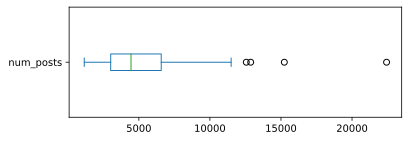

In [40]:
# horizontal boxplot of a dataframe column
cat_df[['num_posts']].plot(kind='box', vert=False, figsize=(6, 2));

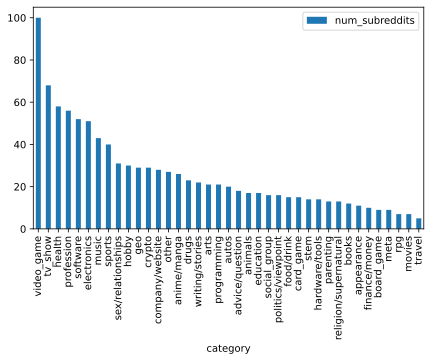

In [41]:
# bar chart of a dataframe column
cat_df[['num_subreddits']].plot(kind='bar', figsize=(7,4));

## Explore word frequencies 

In [42]:
# create a data frame slice
sub_df = df[df['subreddit']=='TheSimpsons']

# sample cleaned text and tokens tagged as nouns
sub_df[['selftext_clean', 'selftext_nouns']].sample(2)

,selftext_clean,selftext_nouns
65540,"Hey guys,\n\nI'm looking for the clip described above. I have no idea what episode or season, but I remember it from quite a few years ago so obviously not anything super recent. But basically Marge is looking for Homer on a workday morning and she goes to find him at Moe's.\n\nAnyone know where it's from?\n\nThanks",guy clip idea episode season year Marge Homer workday morning Moe thank
123482,"Hello r/TheSimpsons, I was trying to explain a scene to a friend the other day and couldn't find the gif anywhere online. Is anyone able to make me a gif of principal Skinner, from the episode Principal Charming. The scene after he and Patty break up, and it just shows a silhouette of him rising, and saying ""tomorrow is another school day""?\n\nThanks if you can :D",r thesimpson scene friend day gif online gif Skinner episode Principal Charming scene Patty silhouette tomorrow school day thank


### Create a list of tokens from a list of documents

In [43]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [44]:
# transform list of documents into a single list of tokens
tokens = sub_df.selftext_nouns.map(my_tokenizer).sum()

In [45]:
print(tokens[:200])

['episode', 'time', 'other', 'instance', 'proposal', 'Putlocker', 'week', 'tv', 'Bart', 'Thanksgiving', 'episode', 'other', 'show', 'girlfriend', 'kid', 'point', 'go', 'show', 'movie', 'thing', 'reference', 'continuity', 'quality', 'reference', 'back', 'movie', 'season', 'Mr.', 'Burns', 'joke', 'consequence', 'callback', 'order', 'problem', 'quality', 'matching', 'movie', 'lot', 'episode', 'show', 'point', 'season', 'dip', 'movie', 'end', 'cap', 'movie', 'cartooniness', 'vibe', 'show', 'hour', 'episode', 'head', 'while', 'guy', 'hope', 'year', 'Lisa', 'boy', 'school', 'parent', 'stuff', 'episode', 'treehouse', 'horror', 'idea', 'idea', 'episode', 'Elijah', 'Wood', 'guest', 'show', '¯\\', 'ツ', 'post', 'time', 'episode', 'episode', 'Homer', 'City', 'New', 'York', 'season', 'episode', 'Youtube', 'min', 'clip', 'Homer', 'car', 'garage', 'Marge', 'homer', 'chore', 'paper', 'car', 'episode', 'name', 'episode', 'Homer', 'bully', 'Kearney', 'joke', 'Homer', 'line', 'guy', 'thank', 'episode', '

### Count frequencies with a counter

In [51]:
counter = Counter(tokens)
counter.most_common(20)

[('episode', 301),
 ('season', 152),
 ('Homer', 139),
 ('Simpsons', 113),
 ('Bart', 71),
 ('show', 70),
 ('year', 66),
 ('time', 48),
 ('scene', 48),
 ('Lisa', 45),
 ('Marge', 42),
 ('joke', 40),
 ('character', 36),
 ('*', 33),
 ('one', 33),
 ('simpson', 32),
 ('people', 32),
 ('thing', 30),
 ('guy', 28),
 ('movie', 26)]

In [52]:
df.category.unique()

array(['writing/stories', 'tv_show', 'autos', 'hardware/tools',
       'electronics', 'video_game', 'crypto', 'sports', 'hobby',
       'appearance', 'card_game', 'drugs', 'advice/question',
       'social_group', 'anime/manga', 'sex/relationships', 'software',
       'health', 'other', 'animals', 'arts', 'programming', 'rpg',
       'books', 'parenting', 'education', 'company/website', 'profession',
       'music', 'politics/viewpoint', 'stem', 'travel', 'geo',
       'religion/supernatural', 'board_game', 'movies', 'food/drink',
       'finance/money', 'meta'], dtype=object)

In [53]:
print([t[0] for t in counter.most_common(200)])   

['episode', 'season', 'Homer', 'Simpsons', 'Bart', 'show', 'year', 'time', 'scene', 'Lisa', 'Marge', 'joke', 'character', '*', 'one', 'simpson', 'people', 'thing', 'guy', 'movie', 'way', 'family', 'thank', 'lot', 'Simpson', 'idea', 'day', 'car', 'line', 'series', 'game', 'a', 'homer', 'b', 'point', 'c', 'reference', 'end', 'place', 'Burns', 'clip', 'Springfield', 'kid', 'Krusty', 'Season', 'Canyonero', 'tv', 'post', 'help', 'bit', 'Ned', 'quote', 'opinion', 'version', 'age', 'memory', 'plot', 'call', 'story', 'name', 'Horror', 'vote', 'Flanders', 'event', 'job', 'voice', 'question', 'fan', 'Apu', 'd', 'Mr.', 'problem', 'head', 'moment', 'Wiggum', 'wife', 'mind', 'example', 'friend', 'gif', 'Moe', 'Scratchy', 'other', 'quality', 'dog', 'Treehouse', 'life', 'video', 'Ralph', 'service', 'sense', '-', 'list', 'aspect', 'roll', 'Itchy', 'Summer', 'school', 'gag', 'title', 'reason', 'today', 'part', 'money', 'effect', 'film', 'DVD', 'writer', 'hand', 'Bob', 'canon', 'advance', 'week', 'minut

In [54]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

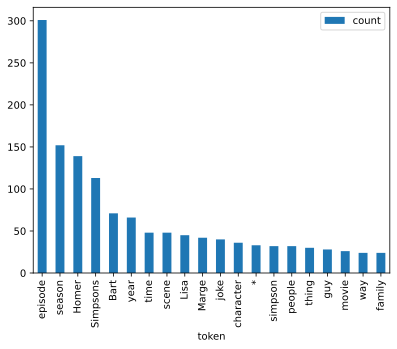

In [55]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

### Use word clouds

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

In [58]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

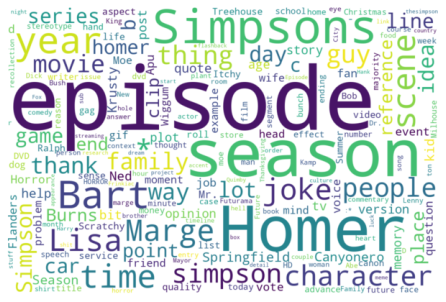

In [59]:
# create wordcloud
wordcloud(counter)

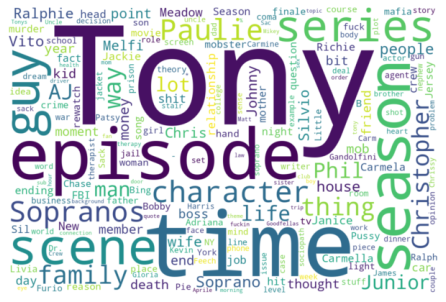

In [60]:
# compare to Sopranos
tokens2 = df[df['subreddit']=='thesopranos'].selftext_nouns \
         .map(my_tokenizer).sum()

counter2 = Counter(remove_stopwords(tokens2))
wordcloud(counter2)

## Explore text complexity

In [61]:
df['no_tokens'] = df.selftext_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

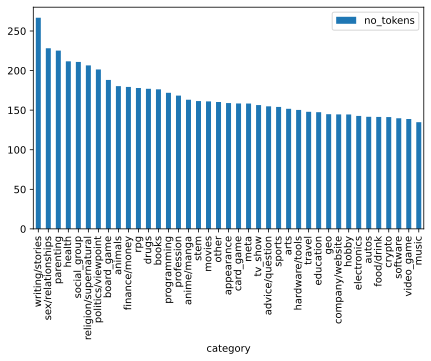

In [62]:
# mean number of tokens by category
df.groupby(['category']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [64]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

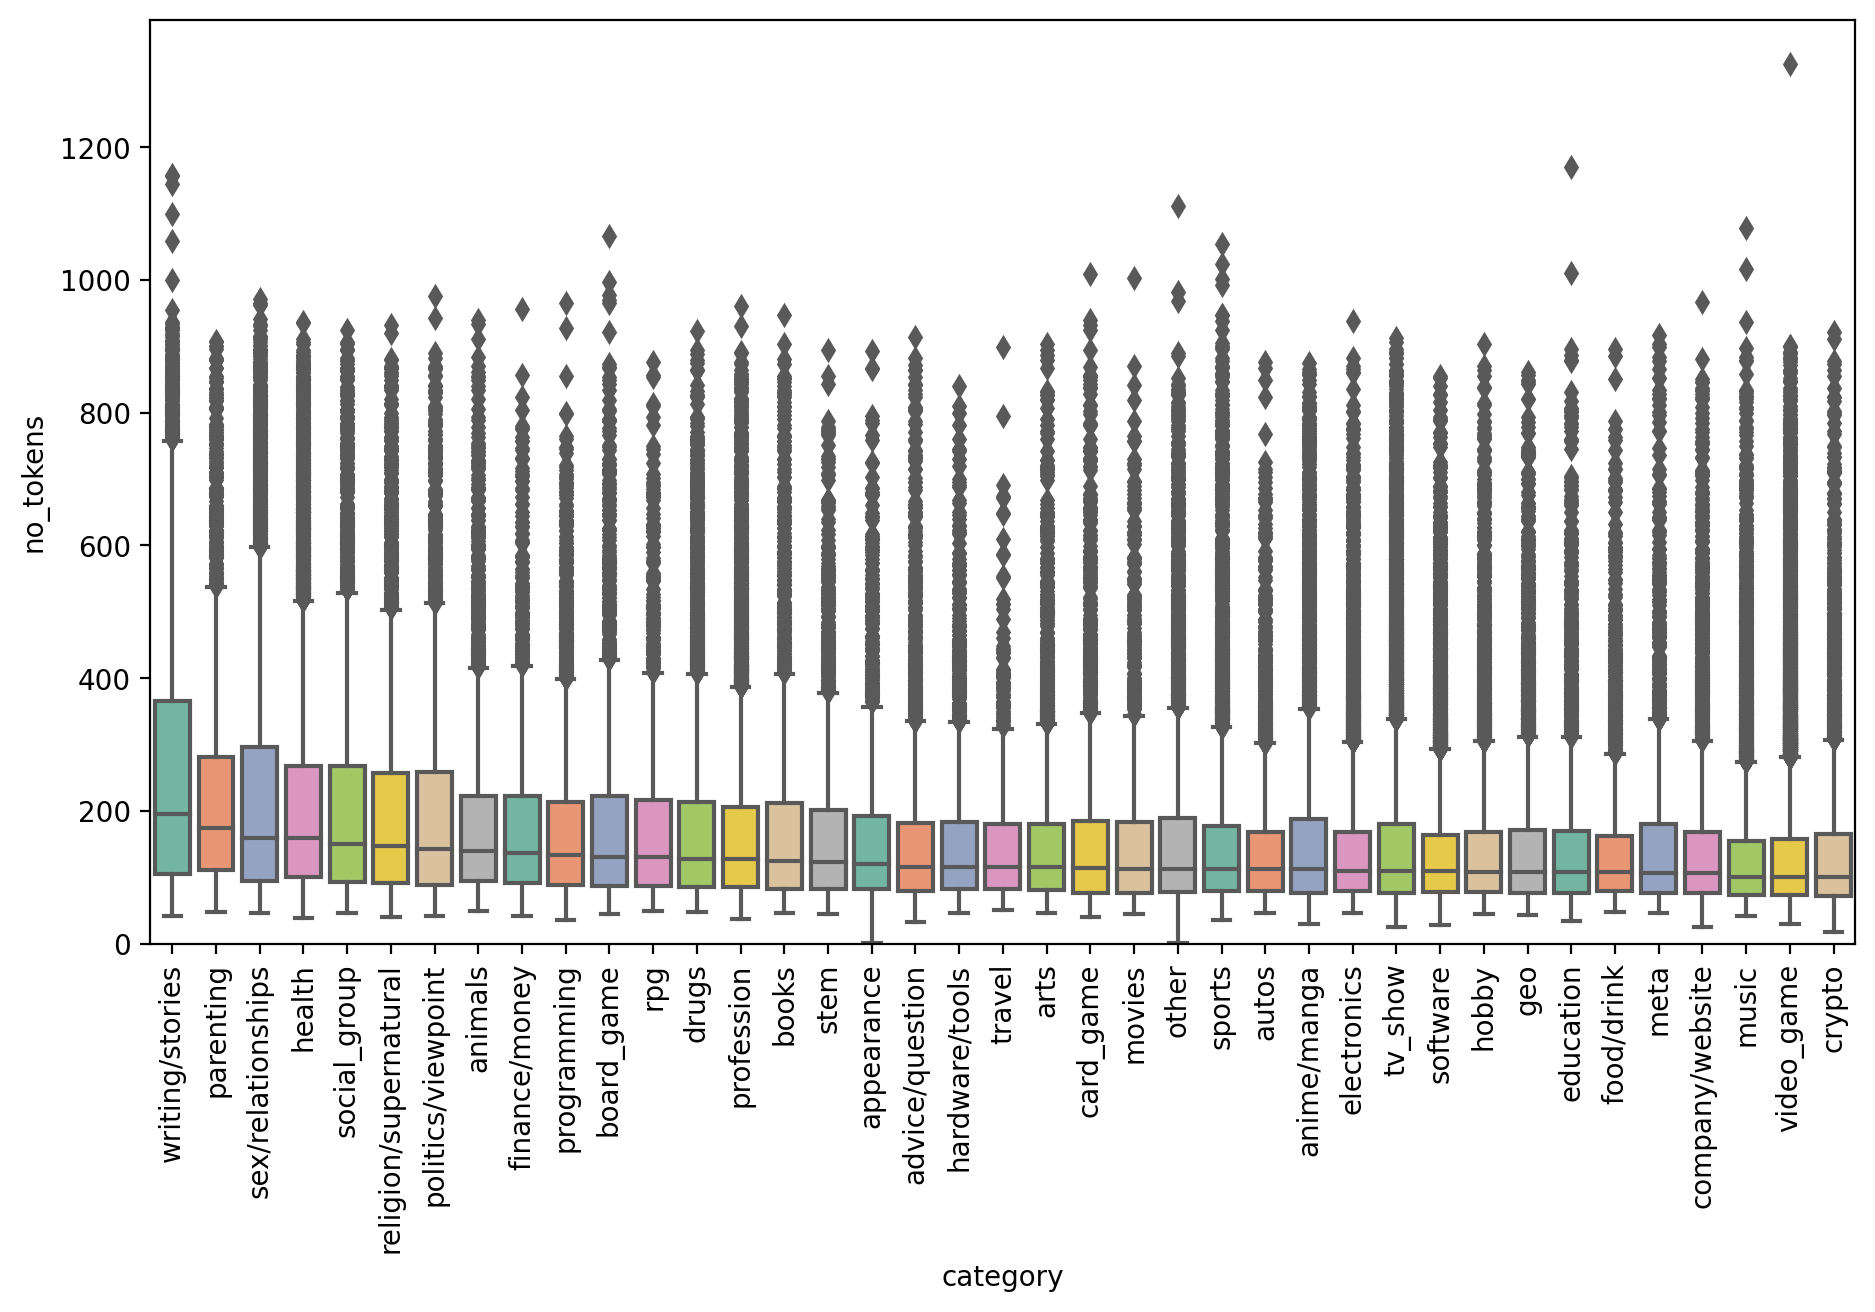

In [65]:
multi_boxplot(df, 'category', 'no_tokens');

In [66]:
# print text of outliers
df['selftext_lemma'][df.no_tokens > 1500]

Series([], Name: selftext_lemma, dtype: object)

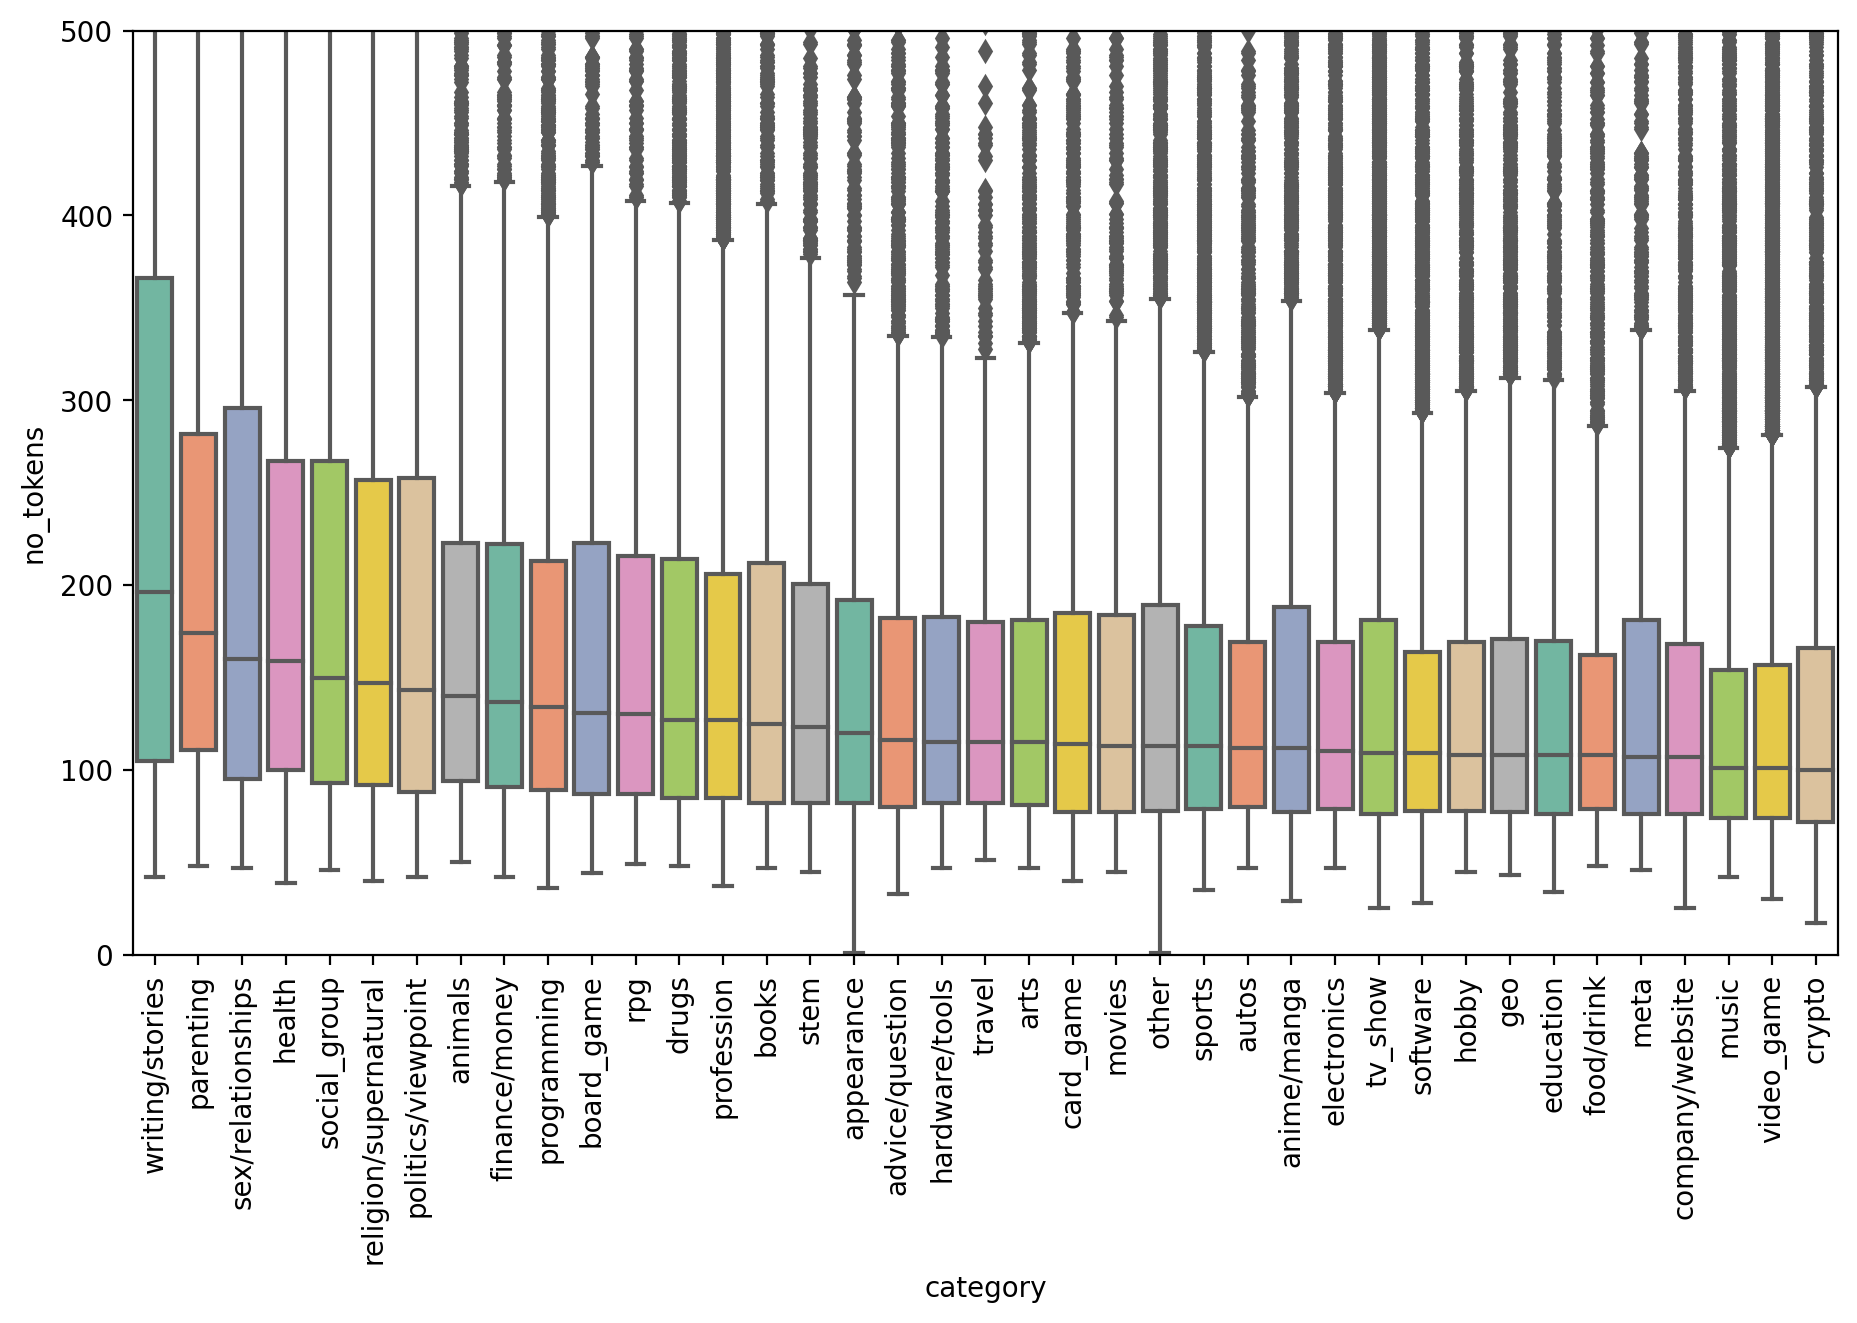

In [67]:
# cut-off diagram at y=500
multi_boxplot(df, 'category', 'no_tokens', ylim=500)

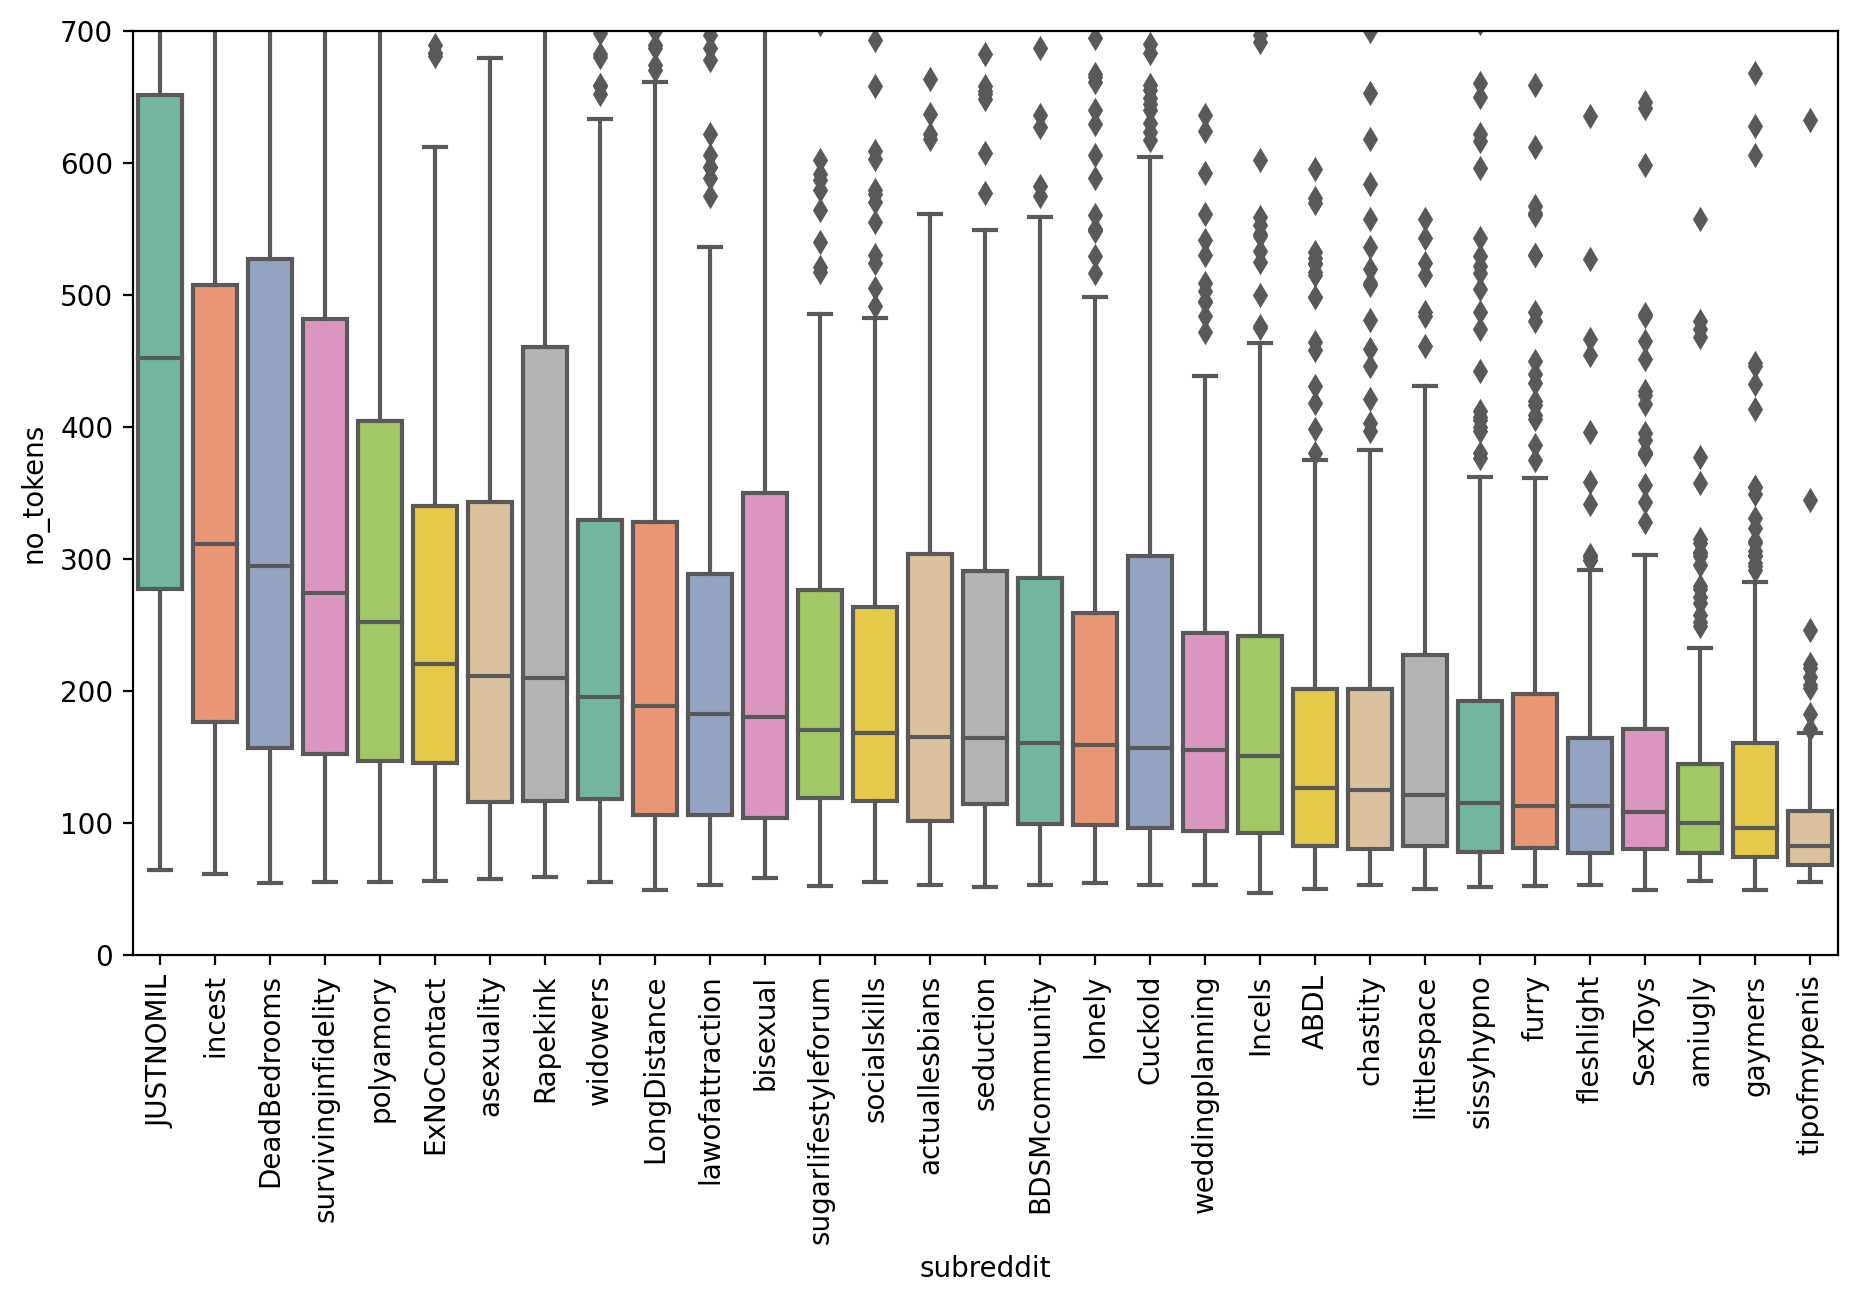

In [68]:
# comparing subreddits within a single category
multi_boxplot(df[df.category=='sex/relationships'], 
              'subreddit', 'no_tokens', ylim=700)